## Experiment 3 - Alternate Approach
- Seeing which algorithm **converges faster**, given a particular unitary size and given error threshold
- <font color = 'green'>Means, let us say the algorithm stopped at $x$ cost. Its target cost, in this iteration, is let's say $y$. Then, which algorithm actually stopped **closer** to the target cost, given the same iterations and resolution is the aim of this experiment.</font>
- Thresholds range from [0.001,0.3] with doubling the threshold at each iteration. 
- Resolution is 30 and max iterations is 12.

In [3]:
error = 0.002
thresholds , targets = [], []
while error < 0.4:
    thresholds.append(error)
    targets.append(round(1-error,3))
    error *= 2
print("Threshold :",thresholds)
print("Target costs :",targets)  

Threshold : [0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256]
Target costs : [0.998, 0.996, 0.992, 0.984, 0.968, 0.936, 0.872, 0.744]


### Metrics Plotted
- The cost returned by the algorithm is plotted in each case 
- Along with cost, the average error from the **closest eigenvalue** is calculated.
- Note that each trial with given error threshold is executed 4 times to get a good estimate of the result. 

### Imports

In [4]:
from qiskit import QuantumCircuit, execute, transpile, Aer 
from qiskit.extensions import UnitaryGate,Initialize
from qiskit.quantum_info import Statevector 
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram,plot_bloch_multivector  
import numpy as np 
from time import sleep 
import sys 
import os 
from scipy.stats import unitary_group 
import matplotlib.pyplot as plt 
%matplotlib inline 

from qiskit import IBMQ 
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-education')
santiago = provider.get_backend('ibmq_santiago')
casablanca = provider.get_backend('ibmq_casablanca')
bogota = provider.get_backend('ibmq_bogota')
sim = Aer.get_backend('qasm_simulator')
athens = provider.get_backend('ibmq_athens')

In [5]:
from normal_SPEA import SPEA 
from changed_SPEA import global_max_SPEA 

### Plotter function

In [41]:
def generate_plots(unitary_size, costs, overlaps, errors_eigen, errors_cost, algorithm):
    import random 
    colors = ['red', 'brown', 'cyan', 'green',
              'grey', 'blue', 'purple', 'black', 'orange']
    c1, c2, c3, c4 = random.sample(colors, 4)

    # plot
    os.makedirs("Experiment_3/"+str(unitary_size) +
                "_qubit(random)/", exist_ok=True)
    # plot 1
    fig = plt.figure(figsize=(13, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title(str(unitary_size)+" qubit "+algorithm +
                  " Cost vs Error threshold", fontsize=16)
    ax1.set_xlabel("Target costs ", fontsize=15)
    ax1.set_ylabel("Metrics Returned for unitary ", fontsize=15)
    # plot metrics
    ax1.plot(targets, costs, label='Costs of Unitary',
             marker='o', color=c1, alpha=0.7)
    ax1.plot(targets, overlaps, label='Average overlap from nearest eigenvector',
             marker='s', color=c2, alpha=0.6)
    ax1.plot()
    ax1.legend(loc='best')
    ax1.grid()
    # plot 2
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title(str(unitary_size)+" qubit "+algorithm +
                  " % Errors v/s thresholds", fontsize=16)
    ax2.set_xlabel("Target Costs", fontsize=15)
    ax2.set_ylabel("% errors", fontsize=15)
    # plot errors
    ax2.plot(targets, errors_eigen, label='Average error from nearest eigenvalue',
             marker='o', color=c3, alpha=0.6)
    ax2.plot(targets, errors_cost, label='Average deviation from desired cost',
             marker='s', color=c4, alpha=0.7)
    ax2.legend(loc='best')
    ax2.grid()
    # save axure
    fig.savefig("Experiment_3/"+str(unitary_size)+"_qubit(random)/" +
                algorithm+" Algorithm (alternate).JPG", dpi=200)

### Result Generator

In [39]:
def get_results(eig_vals, eig_vect, unitary, algorithm, experiments):
    '''Return the results of running the algorithm for this particular unitary matrix'''
    costs_g = []
    errors_eig_g = []
    max_overlaps_g = []
    errors_costs_g = []
    # find how the cost converges with increasing iterations
    for error, target in zip(thresholds, targets):
        costs = []
        errors_eig = []
        errors_costs = []
        overlaps = []
        # run the experiments ...
        for exp in range(experiments):
            if algorithm == 'original':
                spea = SPEA(unitary, resolution=30, max_iters=10)
            else:
                spea = global_max_SPEA(unitary, resolution=30, max_iters=10)

            result = spea.get_eigen_pair(
                progress=False, backend=sim, target_cost=target, algo='alternate')

            # get the results
            costs.append(result['cost'])
            theta = result['theta']
            res_state = result['state']

            # find the abs difference in this theta with the closest eigenvalue
            # and append that to the errors ...
            min_error = 1e5
            for e in eig_vals:
                error = abs(e - theta)
                if error < min_error:
                    min_error = error
                    perc_error = ((error)/e)*100
            errors_eig.append(perc_error)

            # append the perc error from original target cost
            if target >= result['cost']:
                deviation = abs(target - result['cost'])/(target)
            else: # if we have stopped with a better cost, no sense of deviation 
                deviation = 0 
            errors_costs.append(deviation*100)

            # find overlaps
            max_overlap = -1
            for k in eig_vect:
                dot = np.linalg.norm(np.dot(k, res_state.conjugate().T))**2
                max_overlap = max(max_overlap, dot)
            overlaps.append(max_overlap)
        print(costs,errors_costs)
        print("Result with", target, " target cost :")
        print("AVG. COST :", np.average(costs))
        print("AVG. EIGENVALUE ERROR :", np.average(errors_eig))
        print("AVG. DEVIATION FROM TARGET COST", np.average(errors_costs))
        
        # append the average result of your algorithm ...
        costs_g.append(np.average(costs))
        errors_eig_g.append(np.average(errors_eig))
        errors_costs_g.append(np.average(errors_costs))
        max_overlaps_g.append(np.average(overlaps))

    return costs_g, errors_eig_g, errors_costs_g, max_overlaps_g

## 1 - qubit unitary

In [36]:
unit = unitary_group.rvs(2)
unit 

array([[-4.66623126e-01-0.53595433j,  6.97407866e-01+0.0929413j ],
       [ 2.72010295e-04-0.70357355j, -4.69410886e-01-0.53351439j]])

- Generate actual eigenvalues to benchmark against.

In [37]:
eig_vals1, eig_vect1 = np.linalg.eig(unit)
eig_vals1 = np.angle(eig_vals1)
e = []
for k in eig_vals1:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals1 = np.array(e)
print("Eigenstates :", eig_vect1)
print("Eigenvalues :", eig_vals1)

Eigenstates : [[ 0.708037  +0.j         -0.46529516-0.53120997j]
 [ 0.46529516-0.53120997j  0.708037  +0.j        ]]
Eigenvalues : [0.75978095 0.5113664 ]


#### Algorithm 1
- Randomized Approach

In [40]:
costs_1qubit_b, errors_eig_1qubit_b,errors_costs_1qubit_b, max_overlaps_1qubit_b = get_results(eig_vals1, eig_vect1, unit, 'original', 4)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
[0.98046875, 0.982421875, 0.986328125, 0.943359375] [1.7566382765531061, 1.5609343687374746, 1.1695265531062122, 5.4750125250501]
Result with 0.998  target cost :
AVG. COST : 0.97314453125
AVG. EIGENVALUE ERROR : 8.279138842205755
AVG. DEVIATION FROM TARGET COST 2.490527930861723
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
[0.955078125, 0.7890625, 0.974609375, 0.939453125] [4.108621987951807, 20.776857429718877, 2.147653112449799, 5.6773970883534135]
Result with 0

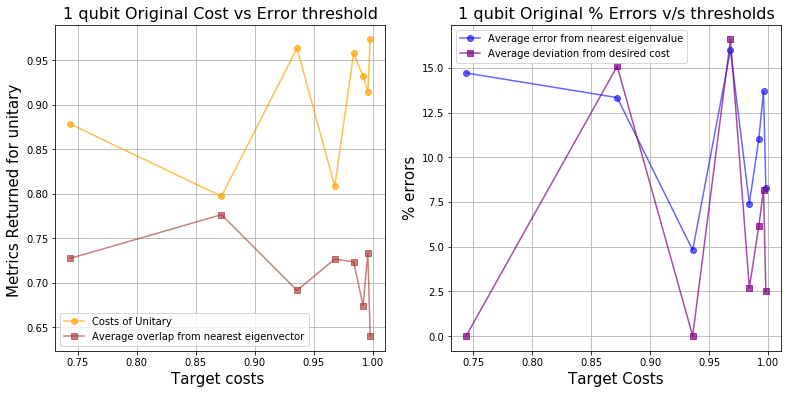

In [42]:
generate_plots(1,costs_1qubit_b,max_overlaps_1qubit_b,errors_eig_1qubit_b,errors_costs_1qubit_b,"Original")

#### Algorithm 2
- Randomized Approach 

In [43]:
costs_1qubit_c, errors_eig_1qubit_c,errors_costs_1qubit_c, max_overlaps_1qubit_c = get_results(eig_vals1, eig_vect1, unit, 'modified', 4)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
[0.978515625, 0.88671875, 0.94140625, 0.796875] [1.9523421843687372, 11.150425851703407, 5.670716432865731, 20.152805611222444]
Result with 0.998  target cost :
AVG. COST : 0.90087890625
AVG. EIGENVALUE ERROR : 15.162287339259787
AVG. DEVIATION FROM TARGET COST 9.731572520040078
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
[0.986328125, 0.958984375, 0.904296875, 0.935546875] [0.971071787148594, 3.7164282128514055, 9.207141064257028, 6.069590863453815]
Result with 0

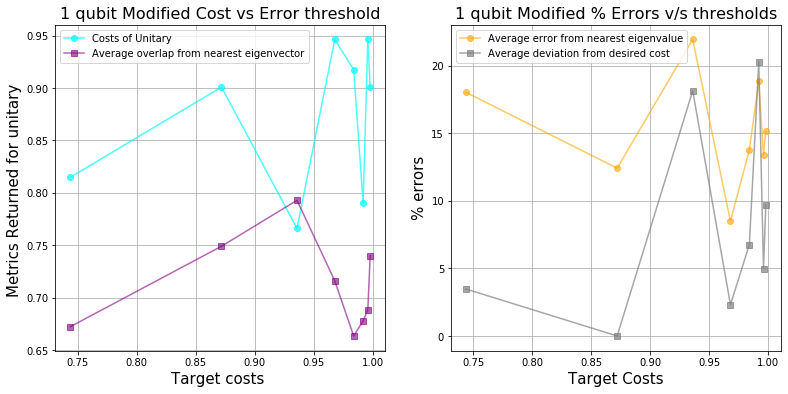

In [44]:
generate_plots(1,costs_1qubit_c,max_overlaps_1qubit_c,errors_eig_1qubit_c,errors_costs_1qubit_c,"Modified")

### Some anomalies detected
- In the running of algorithm 1 and algorithm 2 for 1 qubit matrices, there were 2 anomalies detected. 
- We had a resultant cost of ~ $40\%$ and ~ $30\%$ in two instances where although the **iterations maxed** out but still the algorithms did not do very well. Is is because the algorithms get stuck in some particular basis direction? How can we mitigate this such that we never have a cost below a certain value... ? 

## 2 - qubit unitary


In [47]:
unit_2 =  unitary_group.rvs(4)
unit_2

array([[ 0.60834975-0.09812224j, -0.34435589-0.6115219j ,
         0.10501604+0.20918903j, -0.11591729-0.24396182j],
       [ 0.09584399+0.41845677j, -0.27774759+0.45403146j,
         0.33045533+0.04303708j,  0.23179136-0.60633277j],
       [-0.27755007+0.04866291j, -0.26103378-0.05505844j,
        -0.75500653-0.05700734j, -0.27013773-0.45074241j],
       [ 0.49676769+0.33137625j, -0.31920801+0.22607052j,
        -0.36566862-0.35659561j,  0.14935721+0.45522353j]])

- Generating eigenvalues to benchmark against


In [48]:
eig_vals2, eig_vect2 = np.linalg.eig(unit_2)
eig_vals2 = np.angle(eig_vals2)
e = []
for k in eig_vals2: 
    if k < 0:
        v = (k + 2*np.pi )/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals2 = np.array(e) 
print("Eigenstates :",eig_vect2)
print("Eigenvalues :",eig_vals2)

Eigenstates : [[ 0.86620489+0.j          0.11519051+0.25749902j  0.12266723+0.35958016j
  -0.12421088+0.10169077j]
 [ 0.03349765+0.33105369j -0.26337492-0.43846746j  0.69988706+0.j
   0.07003884+0.36457367j]
 [-0.03374435-0.10273245j -0.22577435-0.05948138j -0.15185864+0.52361707j
   0.79784672+0.j        ]
 [ 0.05206172+0.35294106j  0.77736301+0.j          0.09579918-0.24372033j
   0.4458099 -0.03324728j]]
Eigenvalues : [0.94548347 0.17964744 0.38721777 0.57691415]


#### Algorithm 1

In [51]:
costs_2qubit_b, errors_eig_2qubit_b,errors_costs_2qubit_b, max_overlaps_2qubit_b = get_results(eig_vals2, eig_vect2, unit_2, 'original', 4)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
[0.87890625, 0.955078125, 0.80859375, 0.958984375] [11.933241482965931, 4.3007890781563125, 18.978582164328657, 3.9093812625250495]
Result with 0.998  target cost :
AVG. COST : 0.900390625
AVG. EIGENVALUE ERROR : 12.586290243756626
AVG. DEVIATION FROM TARGET COST 9.780498496993987
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
[0.89453125, 0.71484375, 0.8828125, 0.96484375] [10.18762550200803, 28.228539156626503, 11.364206827309237, 3.1281375502008024]
Result with 0.

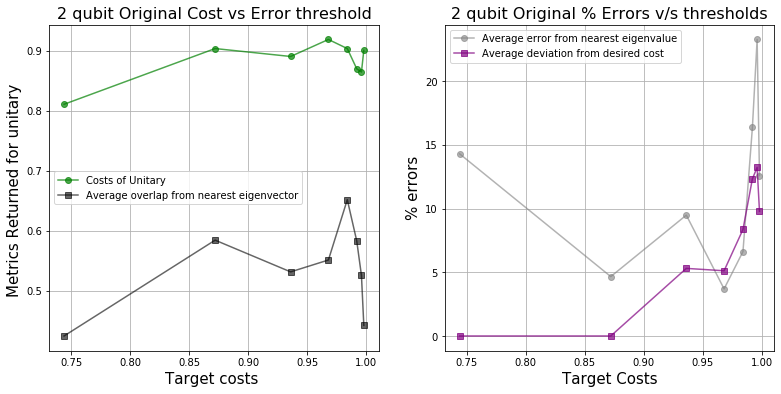

In [52]:
generate_plots(2,costs_2qubit_b,max_overlaps_2qubit_b,errors_eig_2qubit_b,errors_costs_2qubit_b,"Original")

#### Algorithm 2

In [53]:
costs_2qubit_c, errors_eig_2qubit_c,errors_costs_2qubit_c, max_overlaps_2qubit_c = get_results(eig_vals2, eig_vect2, unit_2, 'modified', 4)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
[0.9609375, 0.83203125, 0.673828125, 0.921875] [3.713677354709419, 16.630135270541082, 32.48215180360721, 7.627755511022044]
Result with 0.998  target cost :
AVG. COST : 0.84716796875
AVG. EIGENVALUE ERROR : 14.653426763763985
AVG. DEVIATION FROM TARGET COST 15.113429984969939
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
[0.841796875, 0.740234375, 0.912109375, 0.890625] [15.482241465863453, 25.679279618473892, 8.422753514056225, 10.579819277108433]
Result with 0.99

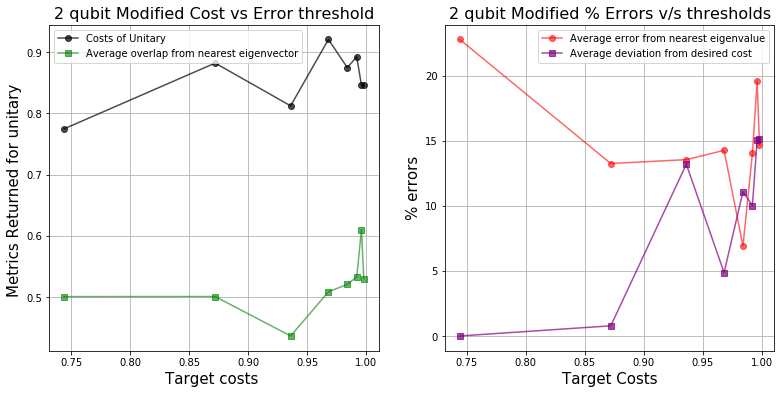

In [54]:
generate_plots(2,costs_2qubit_c,max_overlaps_2qubit_c,errors_eig_2qubit_c,errors_costs_2qubit_c,"Modified")

## Inference
- The inference from these plots is that the algorithms perform fairly similarly when run against each other. 
- One main advantage of the global maximum approach lies in the fact that there is a speedup incurred in the running of the circuits on actual quantum computers. **Global_max** approach contains independent circuits which can be run as a particular job so as to <font color ='orange'>reduce the **network latency** and **API call time** on the actual backends.</font>

## 3 - qubit unitary

In [55]:
unit_3 = unitary_group.rvs(8)
unit_3 

array([[-0.07450835-5.73338803e-03j,  0.03716449-2.58946848e-01j,
         0.29343464+5.46297143e-01j,  0.27542622+8.35837413e-02j,
        -0.02343625-1.34804498e-01j, -0.22456874-3.63622482e-01j,
        -0.33635609-4.39777711e-02j,  0.28526456+2.46518547e-01j],
       [-0.02463897-1.31814845e-01j,  0.36108071+3.54818046e-02j,
         0.38040727-2.57698549e-01j,  0.03516214-2.29015994e-01j,
         0.58181656-8.49352113e-02j, -0.08899418-1.35974282e-02j,
        -0.07785706-6.17890028e-02j, -0.34590523+3.19714268e-01j],
       [ 0.37293379-5.33233453e-04j,  0.44214977-6.69063225e-02j,
        -0.14840416+2.49774824e-01j,  0.37051253-2.04989437e-01j,
        -0.0017178 +2.32349424e-03j,  0.09484406+4.11415748e-01j,
         0.23099135+3.43844663e-01j,  0.19117724+1.04087528e-01j],
       [-0.02302645+2.37996361e-01j, -0.35185137+4.37796016e-02j,
        -0.17735739+2.35071748e-01j, -0.0198246 -2.08315905e-01j,
         0.29320232-2.04303765e-01j, -0.35364972-2.24543242e-01j,
       

In [56]:
eig_vals3, eig_vect3 = np.linalg.eig(unit_3)
eig_vals3 = np.angle(eig_vals3)
e = []
for k in eig_vals3:
    if k < 0:
        v = (k + 2*np.pi )/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals3 = np.array(e) 
print("Eigenstates :",eig_vect3)
print("Eigenvalues :",eig_vals3)

Eigenstates : [[ 0.15375062+0.40819369j -0.28697288-0.31592332j  0.24887739+0.26382225j
  -0.12483038+0.19665677j -0.30428685+0.05147094j -0.02996298-0.32061789j
   0.23377171-0.42893659j  0.03311578+0.05579617j]
 [-0.15683605+0.37268114j  0.04564973-0.03073394j  0.26281441-0.27275645j
   0.59782761+0.j         -0.09467633+0.01341126j -0.00246067-0.31976031j
   0.03712057+0.39647749j -0.0057311 -0.25023196j]
 [-0.01260367+0.1077381j   0.14094085+0.35747592j -0.36022074+0.12204962j
   0.33418987+0.1448115j   0.24087742-0.40855739j -0.06122799-0.32914535j
  -0.04829013-0.42655866j -0.19364998+0.06678935j]
 [ 0.44099429+0.j          0.56191446+0.j          0.20069334-0.26389354j
   0.02401702+0.07925253j -0.09653457+0.08880755j  0.53452932+0.j
   0.02939593-0.16470958j -0.12301594+0.16415599j]
 [ 0.24603894+0.1854739j  -0.17019951-0.13824733j -0.17917932+0.11788214j
   0.35032466-0.16135503j  0.21966878-0.10158906j  0.28804914+0.30909877j
   0.02521104-0.08255114j  0.64628204+0.j        ]

#### Algorithm 1

In [ ]:
costs_3qubit_b, errors_eig_3qubit_b,errors_costs_3qubit_b, max_overlaps_3qubit_b = get_results(eig_vals3, eig_vect3, unit_3, 'original', 4)
generate_plots(3,costs_3qubit_b,max_overlaps_3qubit_b,errors_eig_3qubit_b,errors_costs_3qubit_b,"Original")

#### Algorithm 2

In [ ]:
costs_3qubit_c, errors_eig_3qubit_c,errors_costs_3qubit_c, max_overlaps_3qubit_c = get_results(eig_vals3, eig_vect3, unit_3, 'modified', 4)
generate_plots(3,costs_3qubit_c,max_overlaps_3qubit_c,errors_eig_3qubit_c,errors_costs_3qubit_c,"Modified")

## 4 - qubit unitary

In [ ]:
unit_4 = unitary_group.rvs(16)
unit_4

- Algorithm 1

In [ ]:
costs = []
thetas = []
# find how the cost converges with increasing resolution
for res in resolutions:
    spea = SPEA(unit_4,resolution=res,error = 3,max_iters=10)
    result = spea.get_eigen_pair(progress=False,backend = casablanca)
    print("Result with",res," resolution :",result)
    costs.append(result['cost'])
    thetas.append(result['theta'])
# plot 
plt.title("4-qubit(basic) unitary cost v/s resolution",fontsize = 16)
plt.xlabel("Resolution ",fontsize = 15)
plt.ylabel("Cost Returned for unitary ",fontsize = 15)
plt.plot(resolutions, costs, label = 'Costs of unitary', marker = 's',color = 'red',alpha = 0.5)
plt.plot(resolutions, thetas, label = 'Eigenvalues', marker = 'o',color = 'cyan',alpha = 0.5)
plt.legend()
plt.grid()
os.makedirs("SPE/Experiment_1/4_qubit/",exist_ok = True)
plt.savefig("SPE/Experiment_1/4_qubit/Basic Algorithm Result",dpi = 200)

- Algorithm 2

In [ ]:
costs = []
thetas = []
# find how the cost converges with increasing resolution
for res in resolutions:
    spea = global_max_SPEA(unit_4,resolution=res,error = 3,max_iters=10)
    result = spea.get_eigen_pair(progress=False,backend = casablanca)
    print("Result with",res," resolution :",result)
    costs.append(result['cost'])
    thetas.append(result['theta'])
    
# plot 
plt.title("4-qubit(modified) unitary cost v/s resolution",fontsize = 16)
plt.xlabel("Resolution ",fontsize = 15)
plt.ylabel("Cost Returned for unitary ",fontsize = 15)
plt.plot(resolutions, costs, label = 'Costs of unitary', marker = 's',color = 'yellow',alpha = 0.7)
plt.plot(resolutions, thetas, label = 'Eigenvalues', marker = 'o',color = 'brown',alpha = 0.5)
plt.legend()
plt.grid()
os.makedirs("SPE/Experiment_1/4_qubit/",exist_ok = True)
plt.savefig("SPE/Experiment_1/4_qubit/Modified Algorithm Result",dpi = 200)